# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import numpy as np
import pandas as pd
import requests
import pickle
import json
import time
import re

from datetime import datetime
from datetime import timedelta
from joblib import Parallel, delayed
from urllib.request import urlopen

pd.set_option('display.max_columns', None)

- We load the data to check how it has been distributed
  - The variables that we will use:
    - 'DNS','IP','Date','Time','Request','Status','Size','Referer','UserAgent'

In [2]:
path = '../Data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','IP','Date','Time','Request','Status','Size','Referer','UserAgent'], engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

- Check rows and columns

In [3]:
Logs_copy.tail()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,None,None,None,NaN
261869,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,None,None,None,NaN
261870,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261871,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261872,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


In [4]:
Logs_copy.shape

(261873, 9)

- Check for null data

In [5]:
Logs_copy.isnull().sum()

DNS               0
IP                0
Date              0
Time              0
Request           0
Status       261387
Size         261872
Referer      261872
UserAgent    261873
dtype: int64

In [6]:
Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


In [7]:
Logs_copy.tail()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,None,None,None,NaN
261869,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,None,None,None,NaN
261870,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261871,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261872,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


- Reorder columns of data

In [8]:
Logs_copy.UserAgent = Logs_copy.Request
Logs_copy.Request = Logs_copy.Date
Logs_copy.Referer = Logs_copy.Time
Logs_copy.Date = Logs_copy.IP
Logs_copy.Time = Logs_copy.IP = np.nan

Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- DNS & IP data split

In [9]:
Logs_copy[['DNS','IP']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [10]:
Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Check how many different Ips exist

In [11]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com', 'akumenius.com', 'akumenius.es',
       'test.akumenius.com'], dtype=object)

In [12]:
len(Logs_copy.IP.unique())

2921

- Time data extraction

In [13]:
Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

#Logs_copy.Time = pd.to_datetime(Logs_copy.Time, format = '%H:%M:%S %z')
Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Date data extraction

In [14]:
Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

#Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [15]:
Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Request & Status data split

In [16]:
Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [17]:
Logs_copy.tail()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200 7528,None,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,None,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [18]:
Logs_copy.head()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Size data extraction

In [19]:
Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200 7528,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,200,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Clean Size data

In [20]:
%%time

Logs_copy.Size = Logs_copy.Size.apply(lambda x: (np.nan if x == '200' else x))

CPU times: user 89.2 ms, sys: 38 µs, total: 89.2 ms
Wall time: 87.7 ms


In [21]:
Logs_copy

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200 7528,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Status data extraction

In [22]:
Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.tail()

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Clean Referer data

In [23]:
%%time

Logs_copy.Referer = Logs_copy.Referer.apply(lambda x: (np.nan if re.search('-"', x) else x.rstrip(x[-1])))

CPU times: user 297 ms, sys: 29 µs, total: 297 ms
Wall time: 296 ms


In [24]:
Logs_copy

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [freegeoip](https://freegeoip.app/)

- We export Ips file for security

In [25]:
Ips_export= Logs_copy.IP.copy()

Ips_export.replace('', 'null', inplace = True)

Ips_export.to_csv('../Data/Ips_export.csv', index = False)

- Ips file recovery

In [26]:
path = '../Data/Ips_export.csv'

Ips_raw = pd.read_csv(path, sep= 'delimiter', engine='python')

Ips_raw.head()

,IP
0,127.0.0.1
1,127.0.0.1
2,127.0.0.1
3,127.0.0.1
4,127.0.0.1


In [27]:
Ips_raw.tail()

,IP
261868,5.255.253.53
261869,74.86.158.107
261870,127.0.0.1
261871,127.0.0.1
261872,127.0.0.1


- Make a copy of the data to be used and we check them

In [28]:
Ips_copy = Ips_raw.copy()
ips_unique = Ips_copy.IP.unique()

In [29]:
len(Ips_copy.IP.unique())

2921

In [30]:
ips_unique

array(['127.0.0.1', '66.249.76.216', '5.255.253.53', ...,
       '217.174.248.179', '188.135.173.80', '206.198.5.33'], dtype=object)

- Function for extract Information freegeoip

In [31]:

localhost = "127.0.0.1"

def extract_info(ip):

    try:
        if ip == localhost:
            return 'localhost'
        else:
            response = urlopen("https://freegeoip.app/json/" + ip)
            data = json.load(response)
            return data  

    except:
        return np.nan

- Test the extraction function

In [32]:
extract_info(ips_unique[1])

{'ip': '66.249.76.216',
 'country_code': 'US',
 'country_name': 'United States',
 'region_code': '',
 'region_name': '',
 'city': '',
 'zip_code': '',
 'time_zone': 'America/Chicago',
 'latitude': 37.751,
 'longitude': -97.822,
 'metro_code': 0}

- Ips Information Extraction

In [33]:
%%time

Info_list = Parallel(n_jobs = 8, backend = "multiprocessing")(map(delayed(extract_info), ips_unique))

CPU times: user 1.25 s, sys: 334 ms, total: 1.59 s
Wall time: 48.4 s


- joblib.Parallel uses the backend module to start worker processes, executing tasks simultaneously on separate CPUs.
- 47.8 s for obtaining the IPS 2921 extraction, too much faster, when using 4 cores and 8 threads

- check the data obtained

In [34]:
Info_list[10]

{'ip': '180.76.6.44',
 'country_code': 'CN',
 'country_name': 'China',
 'region_code': '',
 'region_name': '',
 'city': '',
 'zip_code': '',
 'time_zone': 'Asia/Shanghai',
 'latitude': 34.7725,
 'longitude': 113.7266,
 'metro_code': 0}

In [35]:
len(Info_list)

2921

- Function for File to pickle

In [36]:
def to_pickle(info):
    with open('geolocation.pickle', 'wb') as file:
        pickle.dump(info, file)

- We export pickle info for security

In [37]:
to_pickle(Info_list)

- Pickle file recovery

In [38]:
ips_info = pd.read_pickle('geolocation.pickle')

- Create variable to join the data obtained with the ones we had

In [39]:
Info = pd.DataFrame(ips_unique, columns=['IP'])
Info.head()

,IP
0,127.0.0.1
1,66.249.76.216
2,5.255.253.53
3,157.55.35.112
4,193.111.141.116


In [40]:
len(Info)

2921

In [41]:
Info['Info'] = ips_info
Info

,IP,Info
0,127.0.0.1,localhost
1,66.249.76.216,"{'ip': '66.249.76.216', 'country_code': 'US', ..."
2,5.255.253.53,"{'ip': '5.255.253.53', 'country_code': 'RU', '..."
3,157.55.35.112,"{'ip': '157.55.35.112', 'country_code': 'US', ..."
4,193.111.141.116,"{'ip': '193.111.141.116', 'country_code': 'DE'..."
...,...,...
2916,46.222.83.180,"{'ip': '46.222.83.180', 'country_code': 'ES', ..."
2917,79.155.78.117,"{'ip': '79.155.78.117', 'country_code': 'ES', ..."
2918,217.174.248.179,"{'ip': '217.174.248.179', 'country_code': 'GB'..."
2919,188.135.173.80,"{'ip': '188.135.173.80', 'country_code': 'IT',..."


- Do a merge by the column of IPs

In [42]:
Logs_copy = Logs_copy.merge(Info, on='IP', how='inner')

- Check the result

In [43]:
Logs_copy

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent,Info
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost
...,...,...,...,...,...,...,...,...,...,...
261868,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,"{'ip': '217.174.248.179', 'country_code': 'GB'..."
261869,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,"{'ip': '217.174.248.179', 'country_code': 'GB'..."
261870,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"{'ip': '188.135.173.80', 'country_code': 'IT',..."
261871,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"{'ip': '188.135.173.80', 'country_code': 'IT',..."


###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

- Extract data from location information

In progress ...

- Extract UserAgent Data

In [44]:
%%time

from device_detector import SoftwareDetector

Devices = Logs_copy.UserAgent

device = Devices.apply(lambda x: SoftwareDetector(x).parse())

print(device)

0                Apache (internal dummy connection)" VLOG=-
1                Apache (internal dummy connection)" VLOG=-
2                Apache (internal dummy connection)" VLOG=-
3                Apache (internal dummy connection)" VLOG=-
4                Apache (internal dummy connection)" VLOG=-
                                ...                        
261868    Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...
261869    Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...
261870    Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
261871    Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
261872                    Mozilla/4.0 (compatible;)" VLOG=-
Name: UserAgent, Length: 261873, dtype: object


- Assign the values

In [46]:
%%time

Logs_copy['Client_Name'] = device.apply(lambda x: x.client_name())
Logs_copy['Client_Type'] = device.apply(lambda x: x.client_type())
Logs_copy['Client_Version'] = device.apply(lambda x: x.client_version())
Logs_copy['Os_Name'] = device.apply(lambda x: x.os_name())
Logs_copy['Os_Version'] = device.apply(lambda x: x.os_version())
Logs_copy['Device_Type'] = device.apply(lambda x: x.device_type())

CPU times: user 2.94 s, sys: 151 ms, total: 3.09 s
Wall time: 3.09 s


- Check the result

In [47]:
Logs_copy

,DNS,IP,Date,Time,Request,Status,Size,Referer,UserAgent,Info,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",localhost,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261868,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,"{'ip': '217.174.248.179', 'country_code': 'GB'...",Mobile Safari,browser,6.0,iOS,6.0,
261869,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,"{'ip': '217.174.248.179', 'country_code': 'GB'...",Mobile Safari,browser,6.0,iOS,6.0,
261870,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"{'ip': '188.135.173.80', 'country_code': 'IT',...",Chrome,browser,28.0.1500.71,Windows,7,desktop
261871,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"{'ip': '188.135.173.80', 'country_code': 'IT',...",Chrome,browser,28.0.1500.71,Windows,7,desktop


In [48]:
Logs_copy.UserAgent[0]

'Apache (internal dummy connection)" VLOG=-'

- The column from which we have extracted the data is deleted

In [49]:
del(Logs_copy['UserAgent'])

Logs_copy.tail()

,DNS,IP,Date,Time,Request,Status,Size,Referer,Info,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
261868,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,"{'ip': '217.174.248.179', 'country_code': 'GB'...",Mobile Safari,browser,6.0,iOS,6.0,
261869,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,"{'ip': '217.174.248.179', 'country_code': 'GB'...",Mobile Safari,browser,6.0,iOS,6.0,
261870,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,"{'ip': '188.135.173.80', 'country_code': 'IT',...",Chrome,browser,28.0.1500.71,Windows,7,desktop
261871,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,"{'ip': '188.135.173.80', 'country_code': 'IT',...",Chrome,browser,28.0.1500.71,Windows,7,desktop
261872,www.akumenius.com,206.198.5.33,02/Mar/2014,03:02:33 +0100,GET /icon.png HTTP/1.1,304,304,NaN,"{'ip': '206.198.5.33', 'country_code': 'US', '...",,,,,,


- Clean Client Data

In [50]:
%%time

Logs_copy.Client_Name = Logs_copy.Client_Name.apply(lambda x: (x[0:6] if re.search('Apache', x) else x))

CPU times: user 208 ms, sys: 3.92 ms, total: 212 ms
Wall time: 210 ms


In [51]:
Logs_copy

,DNS,IP,Date,Time,Request,Status,Size,Referer,Info,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,localhost,Apache,generic,None,,,
1,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,localhost,Apache,generic,None,,,
2,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,localhost,Apache,generic,None,,,
3,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,localhost,Apache,generic,None,,,
4,localhost,127.0.0.1,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,localhost,Apache,generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261868,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,"{'ip': '217.174.248.179', 'country_code': 'GB'...",Mobile Safari,browser,6.0,iOS,6.0,
261869,localhost,217.174.248.179,02/Mar/2014,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,"{'ip': '217.174.248.179', 'country_code': 'GB'...",Mobile Safari,browser,6.0,iOS,6.0,
261870,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,"{'ip': '188.135.173.80', 'country_code': 'IT',...",Chrome,browser,28.0.1500.71,Windows,7,desktop
261871,www.akumenius.com,188.135.173.80,02/Mar/2014,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,"{'ip': '188.135.173.80', 'country_code': 'IT',...",Chrome,browser,28.0.1500.71,Windows,7,desktop


- Visualize the data in progress

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:

Logs_copy.Location.value_counts(normalize=False).where(Logs_copy.Location.value_counts() > 2000).plot(kind = 'pie', figsize = (10,6))

In [ ]:
graph = Logs_copy[['DNS', 'Location']].groupby(['DNS']).count().sort_values(by = 'Location',ascending = False)
graph = graph.rename(columns = {'Location' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

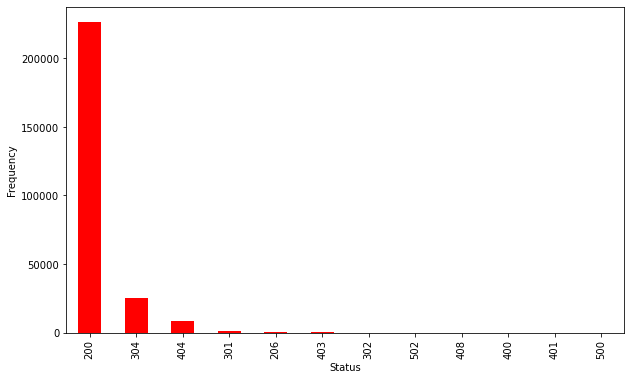

In [54]:
graph = Logs_copy[['Status', 'Time']].groupby(['Status']).count().sort_values(by = 'Time',ascending = False)
graph = graph.rename(columns = {'Time' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

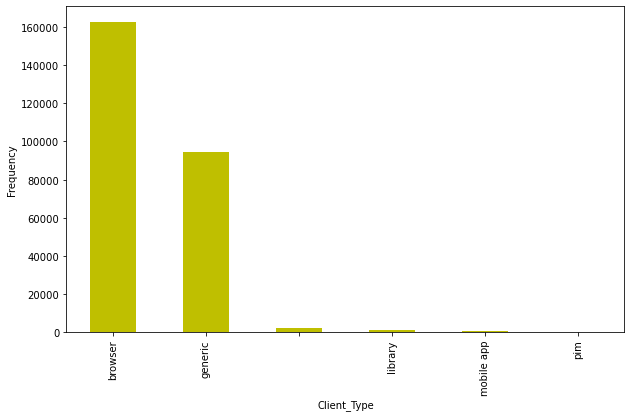

In [55]:
graph = Logs_copy[['Client_Type', 'Time']].groupby(['Client_Type']).count().sort_values(by = 'Time',ascending = False)
graph = graph.rename(columns = {'Time' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'y', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

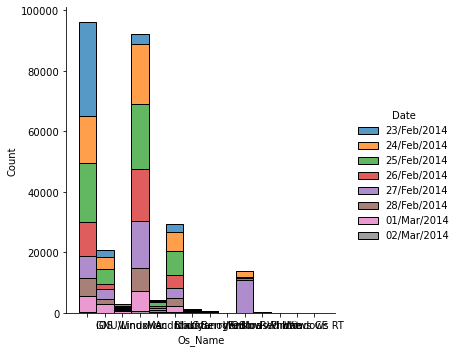

In [56]:
sns.displot(data = Logs_copy, x = "Os_Name", hue = "Date", multiple = "stack")

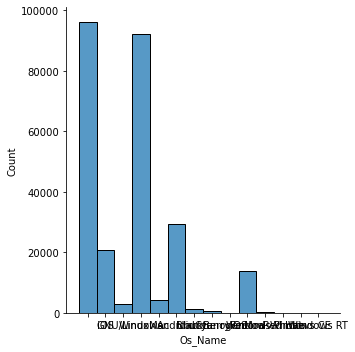

In [57]:
sns.displot(Logs_copy.Os_Name)

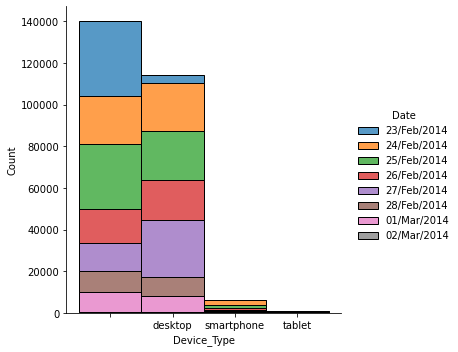

In [58]:
sns.displot(data = Logs_copy, x = "Device_Type", hue = "Date", multiple = "stack")

- Save the data obtained for later reuse

In [59]:
Logs_export = Logs_copy.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('../Data/Logs_export.csv', index = False)